# Atividade de Clusterização

- **Aluno:** Maruan Biasi El Achkar
- **GitHub:** https://github.com/MachineNeyarning/SeismicCluster

### Dataset escolhido: Global Earthquake-Tsunami Risk Assessment Dataset
- Fonte: https://www.kaggle.com/datasets/ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset
- Objetivo: Clusterização geográfica - Iidentificar regiões do mundo com perfis sísmicos semelhantes.

### Algoritmos escolhidos:
- K-Means (Não ideal para esse dataset e objetivo, pois força uma quantidade de clusters)
- DBSCAN (Ideal para esse dataset e objetivo, pois descobre naturalmente a quantidade de clusters)

---

In [54]:
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
!pip install cartopy --quiet
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [55]:
path = kagglehub.dataset_download("ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'global-earthquake-tsunami-risk-assessment-dataset' dataset.
Path to dataset files: /kaggle/input/global-earthquake-tsunami-risk-assessment-dataset


In [56]:
dataset_file = os.path.join(path, 'earthquake_data_tsunami.csv')

df = pd.read_csv(dataset_file)

display(df.head(3))

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.0,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.0,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.0,-20.0508,-178.346,2022,11,1


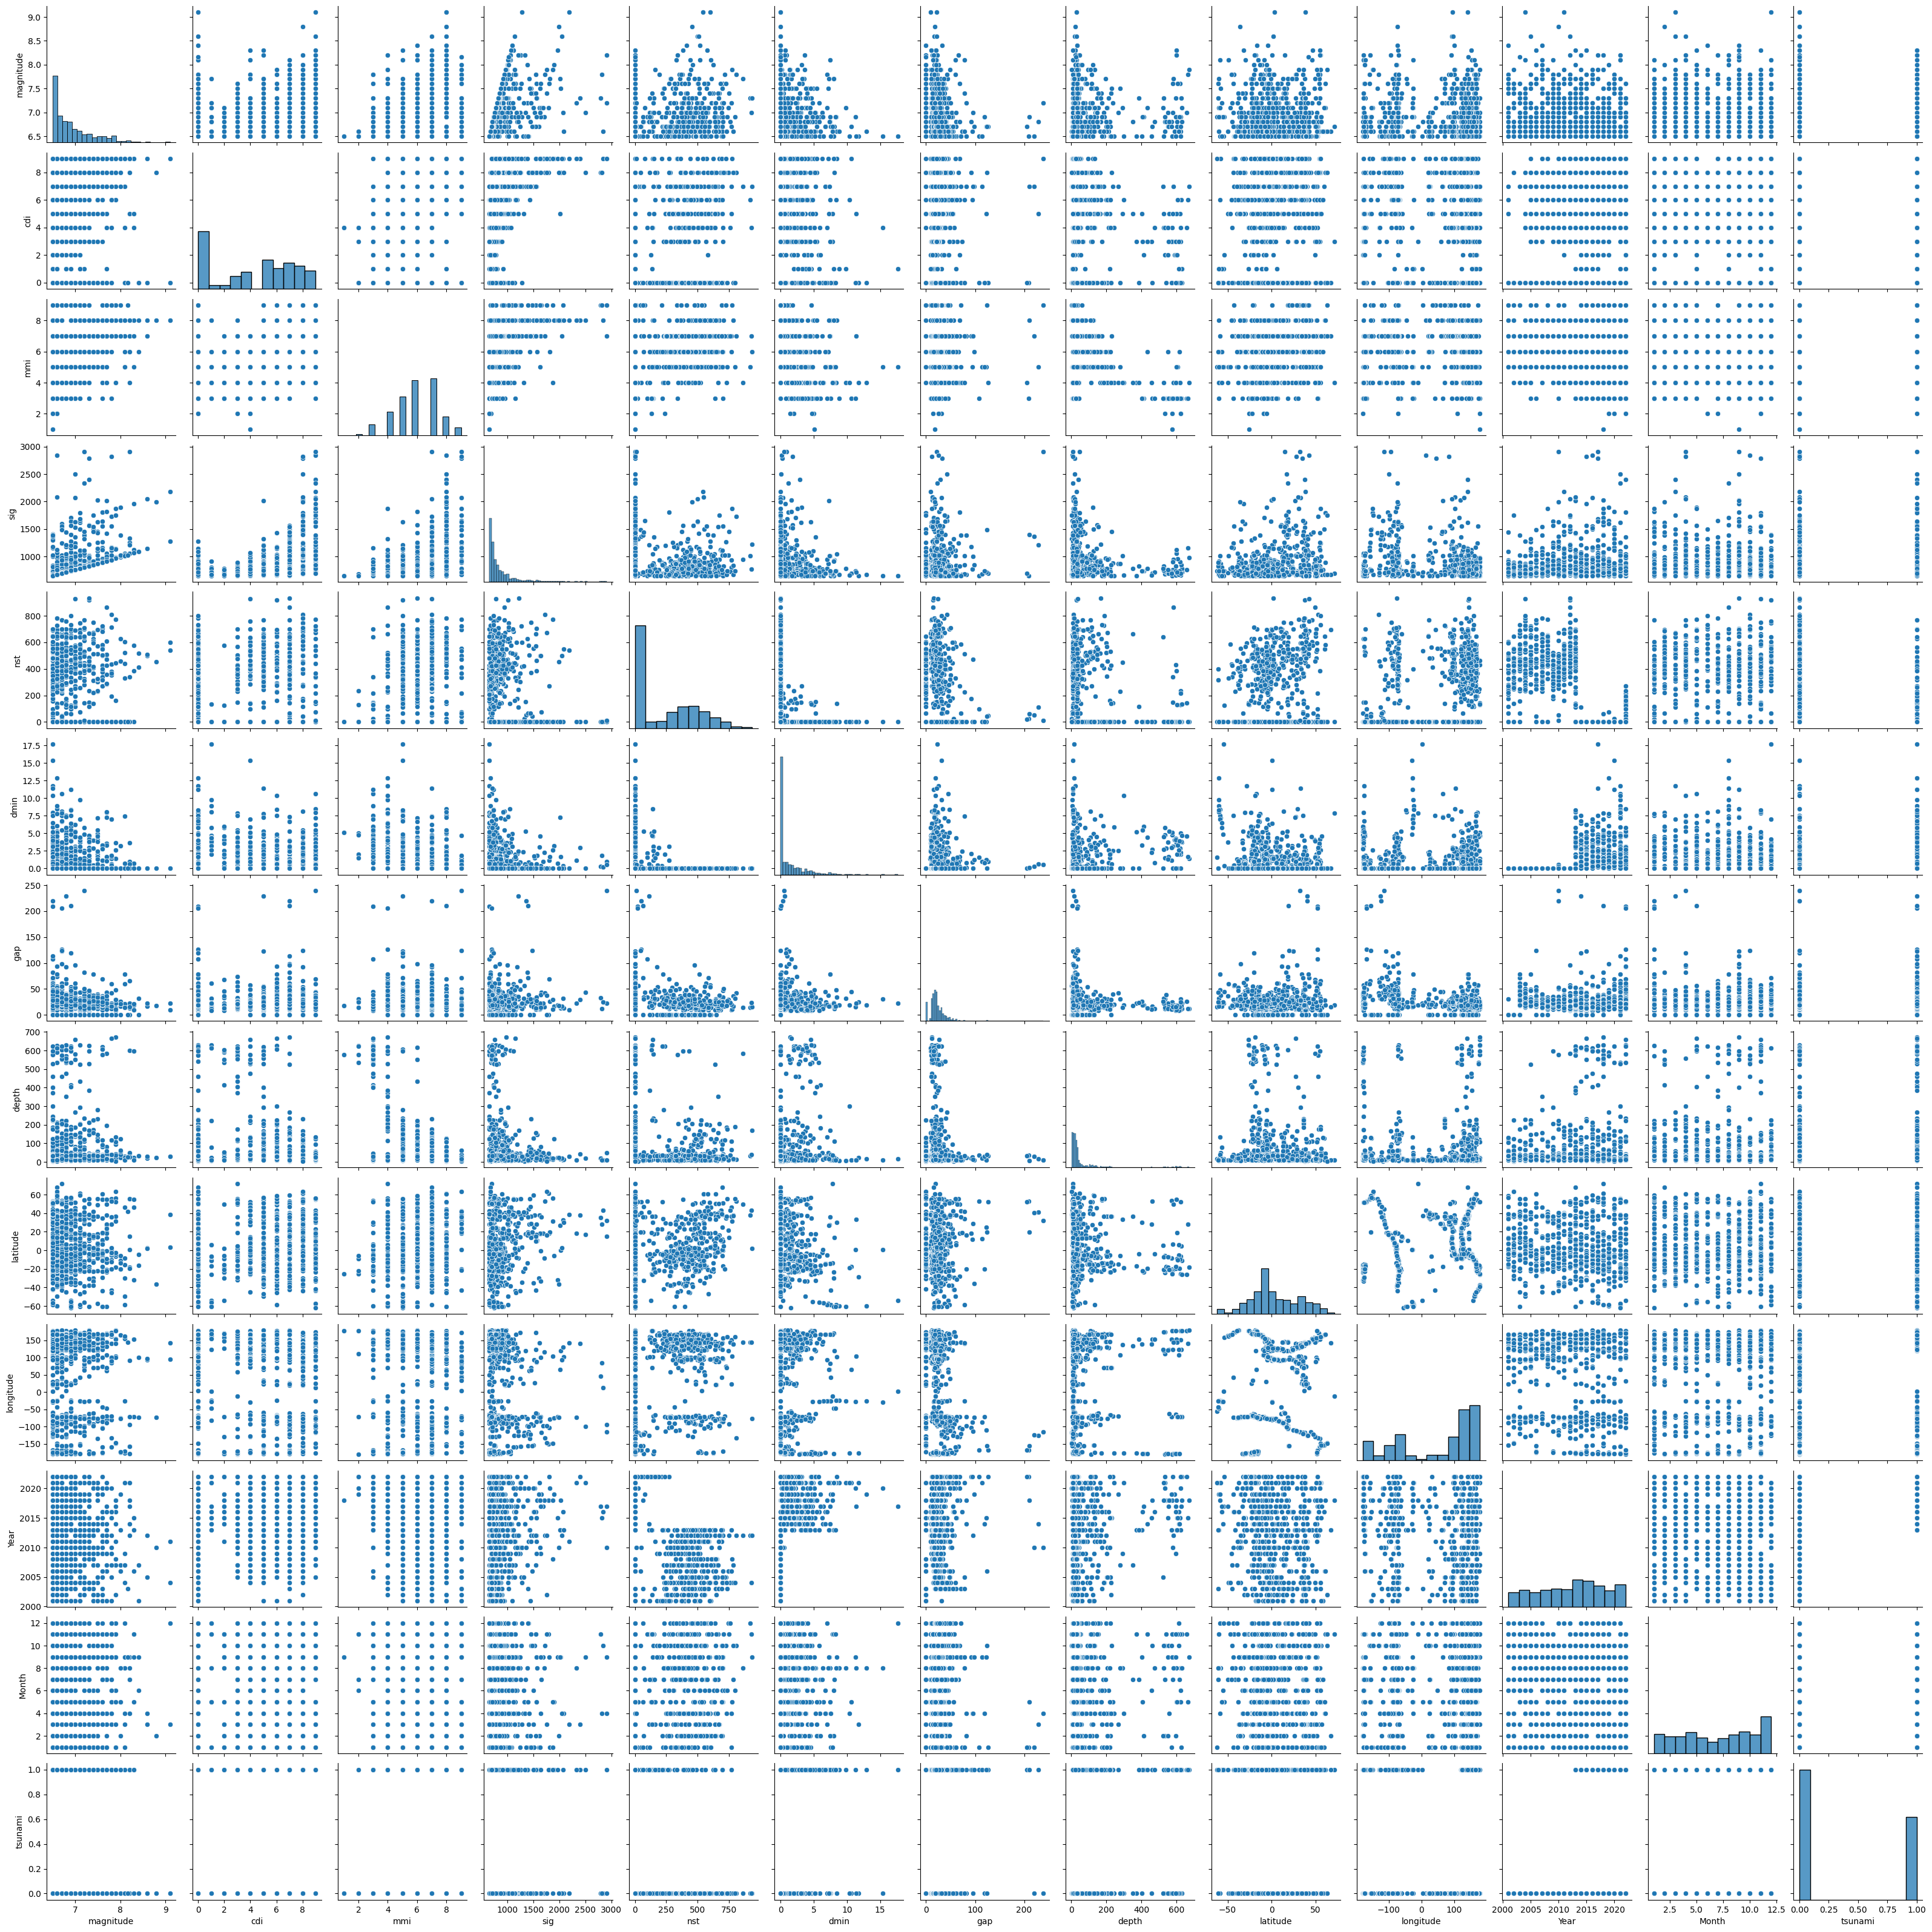

In [57]:
sns.pairplot(df)

In [58]:
# verificar se dados estao inteiros
cols_ok = {"magnitude","depth","latitude","longitude"}
assert cols_ok.issubset(df.columns), f"Faltam colunas: {cols_ok - set(df.columns)}"

In [59]:
# features para K-MEANS
features_kmeans = df[["latitude","longitude","magnitude","depth"]].copy()

# features para DBSCAN
coords_deg = df[["latitude","longitude"]].to_numpy()

# K-Means

In [60]:
scaler = StandardScaler()
X_km = scaler.fit_transform(features_kmeans)

In [61]:
k_range = range(2, 9)
sil_scores = []
inertias = []
best_k = None
best_score = -1
best_labels_kmeans = None
best_model_kmeans = None

In [62]:
for k in k_range:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X_km)
    score = silhouette_score(X_km, labels)
    inertia = km.inertia_

    sil_scores.append(score)
    inertias.append(inertia)

    if score > best_score:
        best_score = score
        best_k = k
        best_labels_kmeans = labels
        best_model_kmeans = km

print(f"[K-Means] Melhor K pelo Silhouette: {best_k} (score={best_score:.3f})")

[K-Means] Melhor K pelo Silhouette: 7 (score=0.394)


In [63]:
df["cluster_kmeans"] = best_labels_kmeans

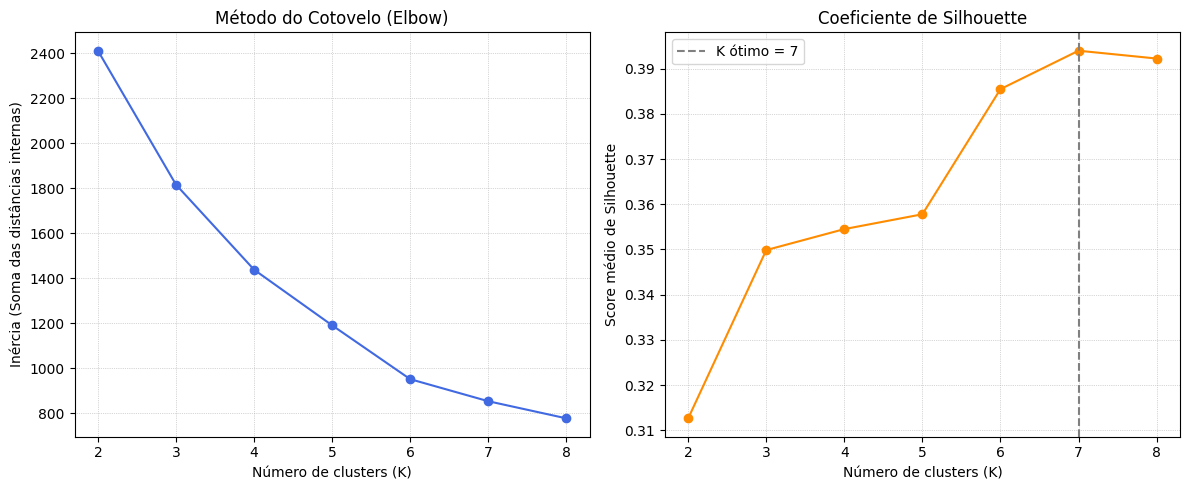

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Elbow ---
axes[0].plot(k_range, inertias, marker='o', color='royalblue')
axes[0].set_title("Método do Cotovelo (Elbow)")
axes[0].set_xlabel("Número de clusters (K)")
axes[0].set_ylabel("Inércia (Soma das distâncias internas)")
axes[0].grid(True, linestyle=":", linewidth=0.5)

# --- Silhouette ---
axes[1].plot(k_range, sil_scores, marker='o', color='darkorange')
axes[1].axvline(best_k, color='gray', linestyle='--', label=f"K ótimo = {best_k}")
axes[1].set_title("Coeficiente de Silhouette")
axes[1].set_xlabel("Número de clusters (K)")
axes[1].set_ylabel("Score médio de Silhouette")
axes[1].grid(True, linestyle=":", linewidth=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

## Mapa dos Resultados K-Means

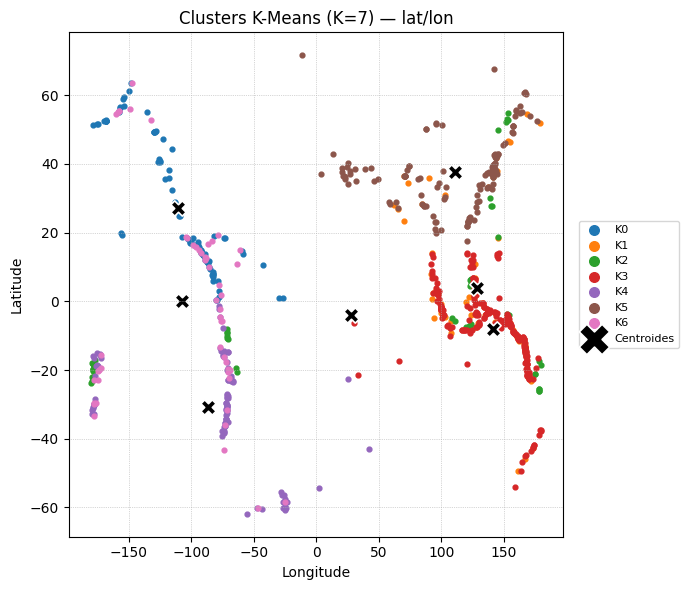

In [65]:
plt.figure(figsize=(7,6))

for lab in np.unique(best_labels_kmeans):
    mask = df["cluster_kmeans"] == lab
    plt.scatter(df.loc[mask,"longitude"], df.loc[mask,"latitude"], s=12, label=f"K{lab}")

# Centroides
centers_scaled = best_model_kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)
plt.scatter(centers_original[:,1], centers_original[:,0],
            c="black", marker="X", s=120, edgecolors="white",
            linewidths=1.2, label="Centroides")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Clusters K-Means (K={best_k}) — lat/lon")

plt.legend(markerscale=2, fontsize=8, loc="center left", bbox_to_anchor=(1.02, 0.5))

plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()


In [66]:
print("\n[K-Means] Contagem por cluster:")
print(df["cluster_kmeans"].value_counts().sort_index())


[K-Means] Contagem por cluster:
cluster_kmeans
0     94
1     76
2     50
3    274
4     97
5    140
6     51
Name: count, dtype: int64


# DBSCAN

In [67]:
coords_rad = np.radians(coords_deg)

In [68]:
EPS_KM = 400.0         # raio de vizinhança em KM
MIN_SAMPLES = 10       # mínimo de pontos na vizinhança para formar cluster

In [69]:
EARTH_RADIUS_KM = 6371.0088
eps_rad = EPS_KM / EARTH_RADIUS_KM

In [70]:
dbs = DBSCAN(eps=eps_rad, min_samples=MIN_SAMPLES, metric="haversine")
labels_dbscan = dbs.fit_predict(coords_rad)

In [71]:
df["cluster_dbscan"] = labels_dbscan

In [72]:
n_clusters_db = len(set(labels_dbscan) - {-1})
noise_pct = (labels_dbscan == -1).mean() * 100
print(f"\n[DBSCAN] nº clusters encontrados: {n_clusters_db}")
print(f"[DBSCAN] % de ruído (label = -1): {noise_pct:.1f}%")

print("\n[DBSCAN] Contagem por rótulo:")
print(pd.Series(labels_dbscan).value_counts().sort_index())


[DBSCAN] nº clusters encontrados: 15
[DBSCAN] % de ruído (label = -1): 26.3%

[DBSCAN] Contagem por rótulo:
-1     206
 0     164
 1      46
 2      35
 3      16
 4      47
 5      52
 6      87
 7      12
 8      12
 9      36
 10     27
 11     10
 12     12
 13     10
 14     10
Name: count, dtype: int64


## Mapa dos Resultados DBSCAN

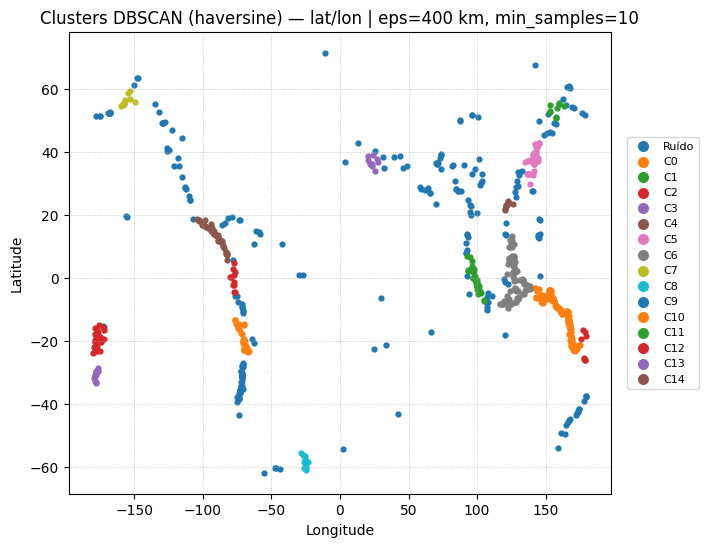

In [73]:
plt.figure(figsize=(7,6))
unique_labels = sorted(set(labels_dbscan))
for lab in unique_labels:
    mask = (labels_dbscan == lab)
    label_txt = f"C{lab}" if lab != -1 else "Ruído"
    plt.scatter(df.loc[mask,"longitude"], df.loc[mask,"latitude"], s=12, label=label_txt)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Clusters DBSCAN (haversine) — lat/lon | eps={EPS_KM:.0f} km, min_samples={MIN_SAMPLES}")

plt.legend(markerscale=2, fontsize=8, loc="center left", bbox_to_anchor=(1.02, 0.5))

plt.grid(True, linestyle=":", linewidth=0.5)
plt.show()

# Comparativo | K-Means VS. DBSCAN

In [74]:
print("\nComparativo primeiros 10 registros (K-Means vs DBSCAN):")
print(df[["latitude","longitude","magnitude","depth","cluster_kmeans","cluster_dbscan"]].head(10))


Comparativo primeiros 10 registros (K-Means vs DBSCAN):
   latitude  longitude  magnitude    depth  cluster_kmeans  cluster_dbscan
0   -9.7963   159.5960        7.0   14.000               3               0
1   -4.9559   100.7380        6.9   25.000               3               1
2  -20.0508  -178.3460        7.0  579.000               2               2
3  -19.2918  -172.1290        7.3   37.000               6               2
4  -25.5948   178.2780        6.6  624.464               2               2
5  -26.0442   178.3810        7.0  660.000               2               2
6  -25.9678   178.3630        6.8  630.379               2               2
7    7.6712   -82.3396        6.7   20.000               0               4
8   18.3300  -102.9130        6.8   20.000               0               4
9   18.3667  -103.2520        7.6   26.943               6               4


## Mapa Comparativo

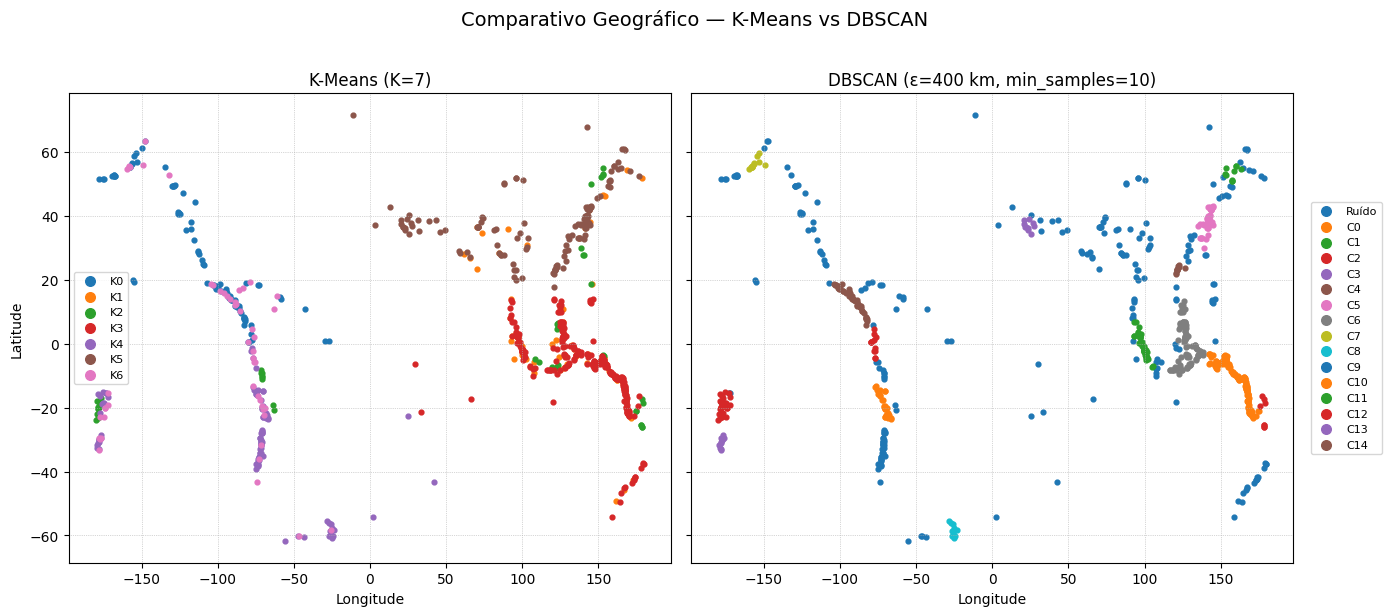

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# K-Means
ax = axes[0]
for lab in np.unique(df["cluster_kmeans"]):
    mask = df["cluster_kmeans"] == lab
    ax.scatter(df.loc[mask,"longitude"], df.loc[mask,"latitude"], s=12, label=f"K{lab}")
ax.set_title(f"K-Means (K={best_k})")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(markerscale=2, fontsize=8)
ax.grid(True, linestyle=":", linewidth=0.5)

# DBSCAN
ax = axes[1]
for lab in sorted(set(labels_dbscan)):
    mask = df["cluster_dbscan"] == lab
    label_txt = f"C{lab}" if lab != -1 else "Ruído"
    ax.scatter(df.loc[mask,"longitude"], df.loc[mask,"latitude"], s=12, label=label_txt)
ax.set_title(f"DBSCAN (ε={EPS_KM:.0f} km, min_samples={MIN_SAMPLES})")
ax.set_xlabel("Longitude")
plt.legend(markerscale=2, fontsize=8, loc="center left", bbox_to_anchor=(1.02, 0.5))
ax.grid(True, linestyle=":", linewidth=0.5)

plt.suptitle("Comparativo Geográfico — K-Means vs DBSCAN", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Mapa Múndi Comparativo

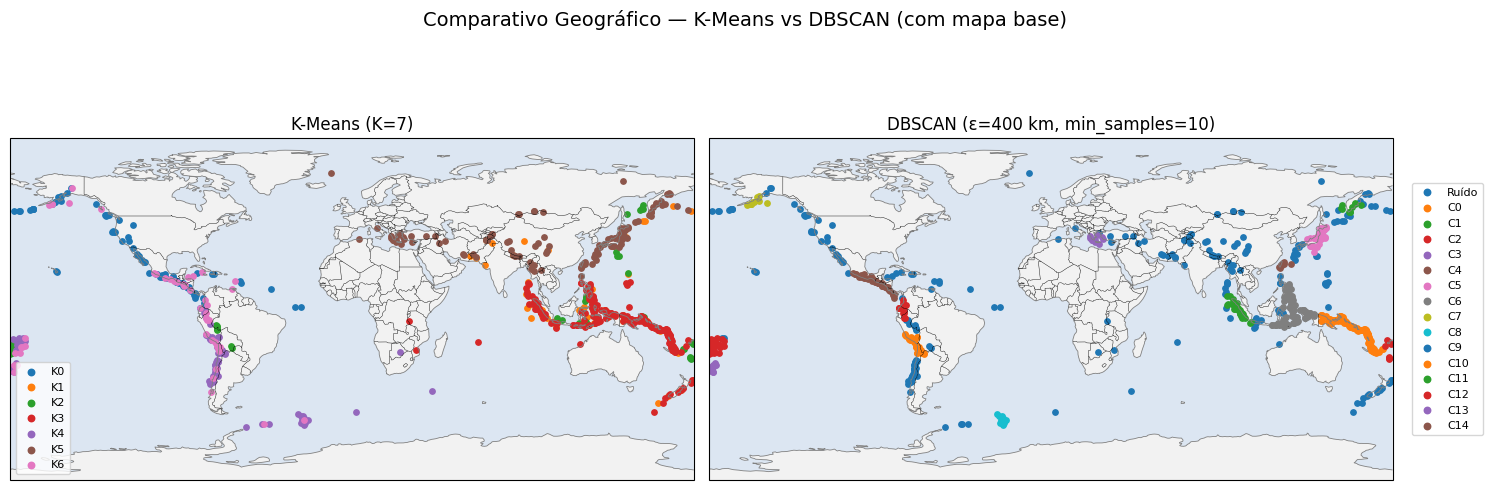

In [76]:
fig = plt.figure(figsize=(15,6))

# K-Means
ax1 = plt.subplot(1,2,1, projection=ccrs.PlateCarree())
ax1.set_global()
ax1.coastlines(linewidth=0.6, color='gray')
ax1.add_feature(cfeature.BORDERS, linewidth=0.3)
ax1.add_feature(cfeature.LAND, facecolor="#f2f2f2")
ax1.add_feature(cfeature.OCEAN, facecolor="#dce6f2")

for lab in np.unique(df["cluster_kmeans"]):
    mask = df["cluster_kmeans"] == lab
    ax1.scatter(df.loc[mask,"longitude"], df.loc[mask,"latitude"],
                s=15, transform=ccrs.PlateCarree(), label=f"K{lab}")
ax1.set_title(f"K-Means (K={best_k})")
ax1.legend(markerscale=1.2, fontsize=8, loc="lower left")

# DBSCAN
ax2 = plt.subplot(1,2,2, projection=ccrs.PlateCarree())
ax2.set_global()
ax2.coastlines(linewidth=0.6, color='gray')
ax2.add_feature(cfeature.BORDERS, linewidth=0.3)
ax2.add_feature(cfeature.LAND, facecolor="#f2f2f2")
ax2.add_feature(cfeature.OCEAN, facecolor="#dce6f2")

for lab in sorted(set(labels_dbscan)):
    mask = df["cluster_dbscan"] == lab
    label_txt = f"C{lab}" if lab != -1 else "Ruído"
    ax2.scatter(df.loc[mask,"longitude"], df.loc[mask,"latitude"],
                s=15, transform=ccrs.PlateCarree(), label=label_txt)
ax2.set_title(f"DBSCAN (ε={EPS_KM:.0f} km, min_samples={MIN_SAMPLES})")
plt.legend(markerscale=1.2, fontsize=8, loc="center left", bbox_to_anchor=(1.02, 0.5))

plt.suptitle("Comparativo Geográfico — K-Means vs DBSCAN (com mapa base)", fontsize=14, y=0.97)
plt.tight_layout()
plt.show()
